In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

In [4]:
# ---------------------------
# 1. Load Data
# ---------------------------
# Tournament game outcomes
tourney_df = pd.read_csv("../raw_data/MNCAATourneyDetailedResults.csv")
# Pre-tournament advanced stats (one row per team per season)
stats_df = pd.read_csv("../pre_tourney_data/PreTournamentAdvancedStats_Adjusted.csv")

stats_df.drop(columns=["Expected Win%"], inplace=True)



In [5]:

# ---------------------------
# 2. Merge Tournament Data with Pre-Tournament Stats
# ---------------------------
# Merge stats for the winning team using Season and WTeamID
merged = tourney_df.merge(
    stats_df,
    left_on=["Season", "WTeamID"],
    right_on=["Season", "TeamID"],
    how="left",
    suffixes=("", "_W")
)
# Merge stats for the losing team using Season and LTeamID
merged = merged.merge(
    stats_df,
    left_on=["Season", "LTeamID"],
    right_on=["Season", "TeamID"],
    how="left",
    suffixes=("", "_L")
)

merged.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,Score_L,Poss_L,ORtg_L,DRtg_L,AdjO_L,AdjD_L,AdjNetRtg_L,SOS_NetRtg_L,SOS_ORtg_L,SOS_DRtg_L
0,2003,134,1421,92,1411,84,N,1,32,69,...,72.800000,70.665000,102.899751,99.110139,98.005282,106.099578,-8.094297,-11.486607,93.519590,105.006197
1,2003,136,1112,80,1436,51,N,0,31,66,...,67.793103,66.252586,102.634717,95.798830,99.568984,98.680569,0.888416,-5.768173,97.054685,102.822859
2,2003,136,1113,84,1272,71,N,0,31,59,...,74.517241,70.600000,105.494080,93.399277,109.970116,92.072583,17.897533,5.593764,101.705202,96.111438
3,2003,136,1141,79,1166,73,N,0,29,53,...,79.242424,69.453788,113.823692,93.090241,114.480227,92.747474,21.732753,0.798965,100.365574,99.566609
4,2003,136,1143,76,1301,74,N,1,27,64,...,72.400000,67.521667,107.202846,101.027518,111.253386,95.967664,15.285722,8.492229,105.010910,96.518682


In [6]:
# ---------------------------
# 3. Create Matchup Difference Features
# ---------------------------
# Compute differences between the winning and losing teams' key metrics.
merged["d_AdjNetRtg"]   = merged["AdjNetRtg"]   - merged["AdjNetRtg_L"]
merged["d_AdjO"]        = merged["AdjO"]        - merged["AdjO_L"]
merged["d_AdjD"]        = merged["AdjD"]        - merged["AdjD_L"]
merged["d_SOS_NetRtg"]  = merged["SOS_NetRtg"]  - merged["SOS_NetRtg_L"]

merged.head(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,AdjO_L,AdjD_L,AdjNetRtg_L,SOS_NetRtg_L,SOS_ORtg_L,SOS_DRtg_L,d_AdjNetRtg,d_AdjO,d_AdjD,d_SOS_NetRtg
0,2003,134,1421,92,1411,84,N,1,32,69,...,98.005282,106.099578,-8.094297,-11.486607,93.519590,105.006197,-9.241894,0.240450,9.482344,4.900043
1,2003,136,1112,80,1436,51,N,0,31,66,...,99.568984,98.680569,0.888416,-5.768173,97.054685,102.822859,26.803562,15.754597,-11.048965,14.286900
2,2003,136,1113,84,1272,71,N,0,31,59,...,109.970116,92.072583,17.897533,5.593764,101.705202,96.111438,1.873527,4.277526,2.403999,3.182406
3,2003,136,1141,79,1166,73,N,0,29,53,...,114.480227,92.747474,21.732753,0.798965,100.365574,99.566609,-13.648518,-5.545112,8.103406,-0.863513
4,2003,136,1143,76,1301,74,N,1,27,64,...,111.253386,95.967664,15.285722,8.492229,105.010910,96.518682,-1.390655,-2.824009,-1.433354,-1.820348
5,2003,136,1163,58,1140,53,N,0,17,52,...,111.394274,90.613227,20.781047,5.988991,105.259011,99.270021,-1.651220,0.352844,2.004065,2.526659
6,2003,136,1181,67,1161,57,N,0,19,54,...,109.840552,103.863979,5.976573,4.944323,102.583355,97.639032,18.344893,6.353949,-11.990944,4.172086
7,2003,136,1211,74,1153,69,N,0,20,47,...,106.862768,90.066596,16.796172,8.877754,105.121814,96.244060,-0.541231,5.463334,6.004565,-5.977086
8,2003,136,1228,65,1443,60,N,0,24,56,...,106.870776,94.779950,12.090826,0.610723,100.352819,99.742096,15.058193,8.009447,-7.048746,6.255984
9,2003,136,1242,64,1429,61,N,0,28,51,...,106.034281,100.047824,5.986457,-3.181381,98.426133,101.607514,24.775610,9.392196,-15.383413,14.712655


In [7]:
# ---------------------------
# 4. Create Training Data for Modeling
# ---------------------------
# For each game, create two rows - one from each team's perspective

# First, create a dataset with Team1 as the reference
team1_features = merged[['Season', 'WTeamID', 'LTeamID', 'd_AdjNetRtg', 'd_AdjO', 'd_AdjD', 'd_SOS_NetRtg']].copy()
team1_features['Team1_Win'] = 1  # The reference team (Team1) won

# Now create a dataset with Team2 as the reference (flip the matchup and negate the differences)
team2_features = merged[['Season', 'LTeamID', 'WTeamID', 'd_AdjNetRtg', 'd_AdjO', 'd_AdjD', 'd_SOS_NetRtg']].copy()
team2_features.rename(columns={'LTeamID': 'WTeamID', 'WTeamID': 'LTeamID'}, inplace=True)
# Negate the differences since we're flipping the perspective
team2_features['d_AdjNetRtg'] = -team2_features['d_AdjNetRtg']
team2_features['d_AdjO'] = -team2_features['d_AdjO']
team2_features['d_AdjD'] = -team2_features['d_AdjD']
team2_features['d_SOS_NetRtg'] = -team2_features['d_SOS_NetRtg']
team2_features['Team1_Win'] = 0  # The reference team (Team1) lost

# Combine the datasets
model_data = pd.concat([team1_features, team2_features], ignore_index=True)

# Rename columns for clarity
model_data.rename(columns={
    'WTeamID': 'Team1',
    'LTeamID': 'Team2',
    'd_AdjNetRtg': 'Team1_AdjNetRtg_vs_Team2',
    'd_AdjO': 'Team1_AdjO_vs_Team2',
    'd_AdjD': 'Team1_AdjD_vs_Team2',
    'd_SOS_NetRtg': 'Team1_SOS_NetRtg_vs_Team2'
}, inplace=True)

print(f"Model data shape: {model_data.shape}")
model_data.head()

Model data shape: (2764, 8)


,Season,Team1,Team2,Team1_AdjNetRtg_vs_Team2,Team1_AdjO_vs_Team2,Team1_AdjD_vs_Team2,Team1_SOS_NetRtg_vs_Team2,Team1_Win
0,2003,1421,1411,-9.241894,0.240450,9.482344,4.900043,1
1,2003,1112,1436,26.803562,15.754597,-11.048965,14.286900,1
2,2003,1113,1272,1.873527,4.277526,2.403999,3.182406,1
3,2003,1141,1166,-13.648518,-5.545112,8.103406,-0.863513,1
4,2003,1143,1301,-1.390655,-2.824009,-1.433354,-1.820348,1


In [8]:
# ---------------------------
# 5. Feature Engineering
# ---------------------------
# Let's create some additional features that might be predictive

# Add interaction terms
model_data['AdjO_x_AdjD'] = model_data['Team1_AdjO_vs_Team2'] * model_data['Team1_AdjD_vs_Team2']
model_data['NetRtg_x_SOS'] = model_data['Team1_AdjNetRtg_vs_Team2'] * model_data['Team1_SOS_NetRtg_vs_Team2']

# Add polynomial features for key metrics
model_data['AdjNetRtg_squared'] = model_data['Team1_AdjNetRtg_vs_Team2'] ** 2

# Feature selection using correlation analysis
correlation = model_data.corr()['Team1_Win'].sort_values(ascending=False)
print("Feature correlations with win outcome:")
print(correlation)

# Select features for modeling
features = [
    'Team1_AdjNetRtg_vs_Team2', 
    'Team1_AdjO_vs_Team2', 
    'Team1_AdjD_vs_Team2', 
    'Team1_SOS_NetRtg_vs_Team2',
    'AdjO_x_AdjD',
    'NetRtg_x_SOS',
    'AdjNetRtg_squared'
]

# Check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = model_data[features]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

# Remove features with high VIF if necessary
high_vif_threshold = 10
high_vif_features = vif_data[vif_data['VIF'] > high_vif_threshold]['Feature'].tolist()
if high_vif_features:
    print(f"\nRemoving features with high multicollinearity: {high_vif_features}")
    features = [f for f in features if f not in high_vif_features]

print(f"\nFinal features for modeling: {features}")

Feature correlations with win outcome:
Team1_Win                    1.000000e+00
Team1_AdjNetRtg_vs_Team2     4.904319e-01
Team1_AdjO_vs_Team2          4.343786e-01
Team1_SOS_NetRtg_vs_Team2    3.995110e-01
Team2                        1.643264e-02
NetRtg_x_SOS                 4.960040e-16
AdjO_x_AdjD                  1.076912e-16
AdjNetRtg_squared            4.188160e-17
Season                      -6.877807e-14
Team1                       -1.643264e-02
Team1_AdjD_vs_Team2         -3.968838e-01
Name: Team1_Win, dtype: float64

Variance Inflation Factors:
                     Feature        VIF
0   Team1_AdjNetRtg_vs_Team2        inf
1        Team1_AdjO_vs_Team2        inf
2        Team1_AdjD_vs_Team2        inf
6          AdjNetRtg_squared  15.797444
4                AdjO_x_AdjD   8.098264
5               NetRtg_x_SOS   7.719118
3  Team1_SOS_NetRtg_vs_Team2   2.766919

Removing features with high multicollinearity: ['Team1_AdjNetRtg_vs_Team2', 'Team1_AdjO_vs_Team2', 'Team1_AdjD_vs_Tea

/Users/ankitdevalla/Projects/MMpred/venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [9]:
# ---------------------------
# 6. Train-Test Split
# ---------------------------
from sklearn.model_selection import train_test_split

# Use more recent seasons as test data (time-based split)
train_seasons = list(range(2003, 2019))  # Train on 2003-2018
test_seasons = list(range(2019, 2025))   # Test on 2019-2024

train_data = model_data[model_data['Season'].isin(train_seasons)]
test_data = model_data[model_data['Season'].isin(test_seasons)]

X_train = train_data[features]
y_train = train_data['Team1_Win']

X_test = test_data[features]
y_test = test_data['Team1_Win']

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Check class balance
print(f"Training class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test class distribution:\n{y_test.value_counts(normalize=True)}")

Training data shape: (2096, 3)
Test data shape: (668, 3)
Training class distribution:
Team1_Win
1    0.5
0    0.5
Name: proportion, dtype: float64
Test class distribution:
Team1_Win
1    0.5
0    0.5
Name: proportion, dtype: float64



Training Logistic Regression...
Cross-validation ROC AUC: 0.7283 ± 0.0256
Test Accuracy: 0.6228
Log Loss: 0.6293
ROC AUC: 0.6878

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62       334
           1       0.62      0.62      0.62       334

    accuracy                           0.62       668
   macro avg       0.62      0.62      0.62       668
weighted avg       0.62      0.62      0.62       668


Training Random Forest...
Cross-validation ROC AUC: 0.7364 ± 0.0280
Test Accuracy: 0.6392
Log Loss: 0.7170
ROC AUC: 0.7310

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       334
           1       0.64      0.64      0.64       334

    accuracy                           0.64       668
   macro avg       0.64      0.64      0.64       668
weighted avg       0.64      0.64      0.64       668


Training Gradient Boosting...
Cross-validat

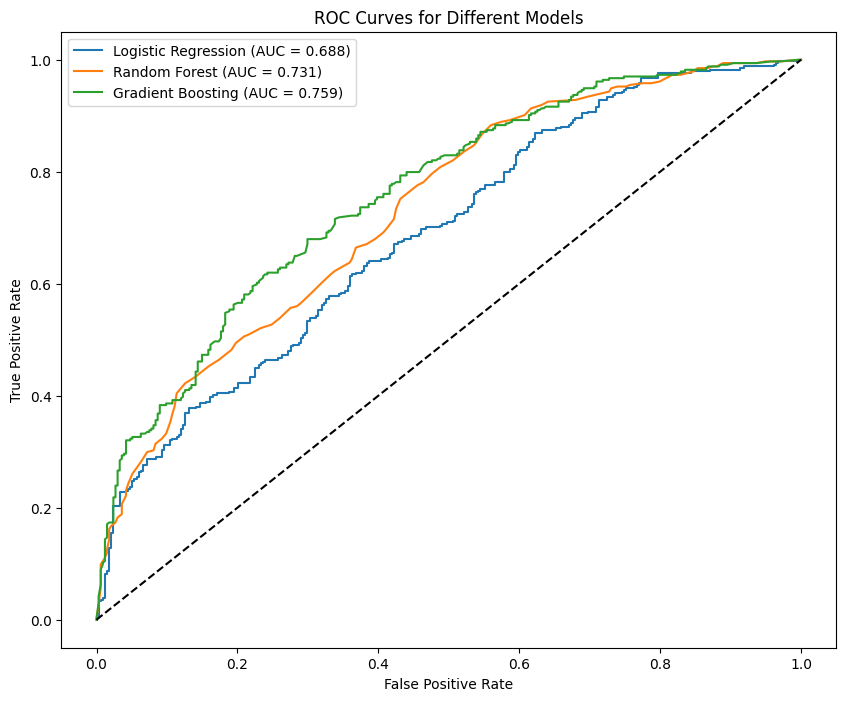


Best model: Gradient Boosting


In [10]:
# ---------------------------
# 7. Model Training and Evaluation
# ---------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation on training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"Cross-validation ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Train on full training set
    model.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Log Loss: {loss:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Store results
    results[name] = {
        'model': model,
        'cv_auc': cv_scores.mean(),
        'test_accuracy': accuracy,
        'test_log_loss': loss,
        'test_auc': auc,
        'y_pred_proba': y_pred_proba
    }

# Compare models
result_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV ROC AUC': [results[m]['cv_auc'] for m in results],
    'Test Accuracy': [results[m]['test_accuracy'] for m in results],
    'Test Log Loss': [results[m]['test_log_loss'] for m in results],
    'Test ROC AUC': [results[m]['test_auc'] for m in results]
})

print("\nModel Comparison:")
print(result_df.sort_values('Test ROC AUC', ascending=False))

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['test_auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()

# Select the best model based on ROC AUC
best_model_name = result_df.sort_values('Test ROC AUC', ascending=False).iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")

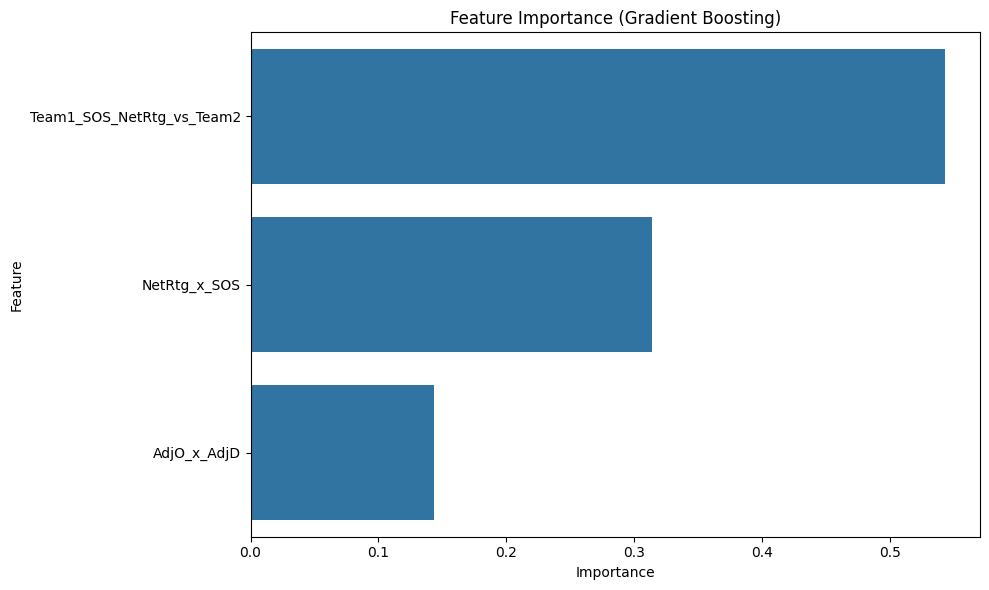

Feature Importance:
                     Feature  Importance
0  Team1_SOS_NetRtg_vs_Team2    0.542956
2               NetRtg_x_SOS    0.313901
1                AdjO_x_AdjD    0.143142


In [11]:
# ---------------------------
# 8. Feature Importance Analysis
# ---------------------------
import seaborn as sns

# Get feature importance based on the best model
if best_model_name == 'Logistic Regression':
    # For logistic regression, use coefficients
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': np.abs(best_model.coef_[0]),
        'Coefficient': best_model.coef_[0]
    })
    importance = importance.sort_values('Importance', ascending=False)
    
    # Plot coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=importance.sort_values('Coefficient'))
    plt.title('Feature Coefficients (Logistic Regression)')
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model, 'feature_importances_'):
    # For tree-based models like Random Forest and Gradient Boosting
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': best_model.feature_importances_
    })
    importance = importance.sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance)
    plt.title(f'Feature Importance ({best_model_name})')
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature importance visualization not implemented for {best_model_name}")

print("Feature Importance:")
print(importance)

Model performance by tournament round:
               Accuracy  Games
Round                         
Championship   0.833333     18
Elite 8        0.645833     48
Final Four     0.650000     20
Play-in games  0.625000     32
Round of 32    0.770115    174
Round of 64    0.648649    296
Sweet 16       0.662500     80


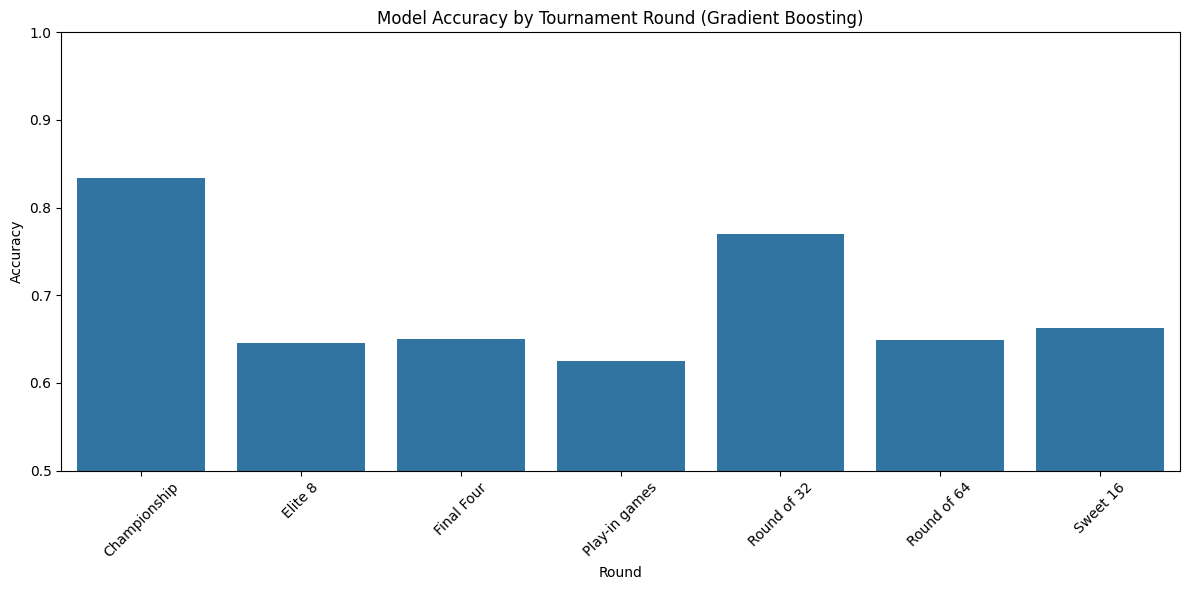

In [12]:
# ---------------------------
# 9. Tournament Round Analysis
# ---------------------------
# Map DayNum to tournament round
def get_round(day_num):
    if day_num < 136:  # First round (Round of 64)
        return "Play-in games"
    elif day_num < 138:  # Second round (Round of 32)
        return "Round of 64"
    elif day_num < 140:  # Sweet 16
        return "Round of 32"
    elif day_num <= 144:  # Elite 8
        return "Sweet 16"
    elif day_num <= 146:  # Final Four
        return "Elite 8"
    elif day_num == 152:  # Semifinals
        return "Final Four"
    else:  # Championship
        return "Championship"

# Add round information to test data
test_with_rounds = test_data.copy()
test_with_rounds['Round'] = test_with_rounds.apply(
    lambda row: get_round(merged[(merged['Season'] == row['Season']) & 
                                (((merged['WTeamID'] == row['Team1']) & (merged['LTeamID'] == row['Team2'])) | 
                                 ((merged['WTeamID'] == row['Team2']) & (merged['LTeamID'] == row['Team1'])))]['DayNum'].values[0]), 
    axis=1
)

# Get predictions for test data
test_with_rounds['predicted_prob'] = best_model.predict_proba(X_test)[:, 1]
test_with_rounds['predicted_winner'] = (test_with_rounds['predicted_prob'] > 0.5).astype(int)
test_with_rounds['correct'] = test_with_rounds['predicted_winner'] == test_with_rounds['Team1_Win']

# Analyze performance by round
round_performance = test_with_rounds.groupby('Round').agg({
    'correct': 'mean',
    'Team1_Win': 'count'
}).rename(columns={'correct': 'Accuracy', 'Team1_Win': 'Games'})

print("Model performance by tournament round:")
print(round_performance)

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=round_performance.index, y='Accuracy', data=round_performance)
plt.title(f'Model Accuracy by Tournament Round ({best_model_name})')
plt.ylim(0.5, 1.0)  # Set y-axis to start at 0.5 for better visualization
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Number of upsets in test data: 214 (32.0% of games)
Accuracy on upset games: 0.1822
Accuracy on non-upset games: 0.9229


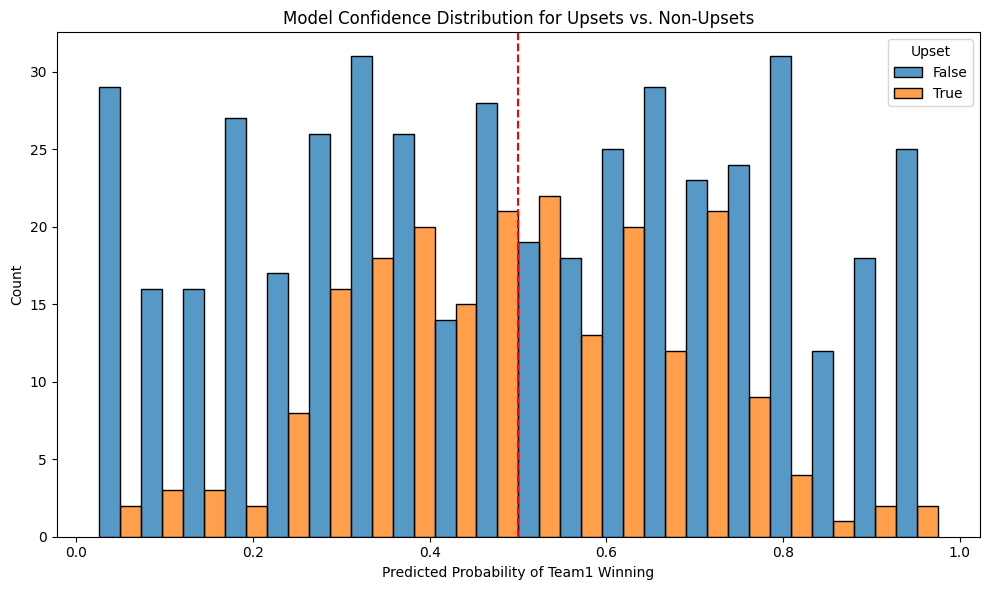

In [13]:
# ---------------------------
# 10. Upset Analysis
# ---------------------------
# Add seed information to test data (you would need to load seed data)
# For now, let's use AdjNetRtg as a proxy for team strength

# Define an upset as when a team with lower AdjNetRtg beats a team with higher AdjNetRtg
test_with_upsets = test_with_rounds.copy()

# Get team stats for both teams
team1_stats = pd.merge(
    test_with_upsets[['Season', 'Team1']],
    stats_df,
    how='left',
    left_on=['Season', 'Team1'],
    right_on=['Season', 'TeamID']
).rename(columns={'AdjNetRtg': 'Team1_AdjNetRtg'})

team2_stats = pd.merge(
    test_with_upsets[['Season', 'Team2']],
    stats_df,
    how='left',
    left_on=['Season', 'Team2'],
    right_on=['Season', 'TeamID']
).rename(columns={'AdjNetRtg': 'Team2_AdjNetRtg'})

test_with_upsets['Team1_AdjNetRtg'] = team1_stats['Team1_AdjNetRtg'].values
test_with_upsets['Team2_AdjNetRtg'] = team2_stats['Team2_AdjNetRtg'].values

# Define upsets
test_with_upsets['Team1_Favored'] = test_with_upsets['Team1_AdjNetRtg'] > test_with_upsets['Team2_AdjNetRtg']
test_with_upsets['Upset'] = (
    (test_with_upsets['Team1_Favored'] & (test_with_upsets['Team1_Win'] == 0)) | 
    (~test_with_upsets['Team1_Favored'] & (test_with_upsets['Team1_Win'] == 1))
)

# Calculate upset prediction accuracy
upset_games = test_with_upsets[test_with_upsets['Upset']]
non_upset_games = test_with_upsets[~test_with_upsets['Upset']]

print(f"Number of upsets in test data: {len(upset_games)} ({len(upset_games)/len(test_with_upsets):.1%} of games)")
print(f"Accuracy on upset games: {upset_games['correct'].mean():.4f}")
print(f"Accuracy on non-upset games: {non_upset_games['correct'].mean():.4f}")

# Analyze model confidence in upsets
plt.figure(figsize=(10, 6))
sns.histplot(
    data=test_with_upsets, 
    x='predicted_prob', 
    hue='Upset',
    bins=20,
    multiple='dodge'
)
plt.title('Model Confidence Distribution for Upsets vs. Non-Upsets')
plt.xlabel('Predicted Probability of Team1 Winning')
plt.axvline(0.5, color='red', linestyle='--')
plt.tight_layout()
plt.show()

In [14]:
# ---------------------------
# 11. Examine Individual Predictions
# ---------------------------
# Load team names from CSV
teams_df = pd.read_csv("../raw_data/MTeams.csv")
teams_dict = dict(zip(teams_df['TeamID'], teams_df['TeamName']))

# Select a sample of games from the test data
sample_size = 15  # Increased sample size to see more examples
sample_games = test_with_upsets.sample(sample_size, random_state=42)

# Create a more readable display of the predictions
prediction_display = []

for _, game in sample_games.iterrows():
    team1_id = game['Team1']
    team2_id = game['Team2']
    team1_netrtg = game['Team1_AdjNetRtg']
    team2_netrtg = game['Team2_AdjNetRtg']
    
    # Get team names from the dictionary
    team1_name = teams_dict.get(team1_id, f"Team {team1_id}")
    team2_name = teams_dict.get(team2_id, f"Team {team2_id}")
    
    # Prediction and actual outcome
    team1_win_prob = game['predicted_prob']
    team2_win_prob = 1 - team1_win_prob
    actual_winner = team1_name if game['Team1_Win'] == 1 else team2_name
    predicted_winner = team1_name if game['predicted_winner'] == 1 else team2_name
    
    # Was this an upset?
    upset_status = "UPSET" if game['Upset'] else "EXPECTED"
    
    # Was the prediction correct?
    prediction_correct = "✓" if game['correct'] else "✗"
    
    # Tournament round
    round_name = game['Round']
    
    # Store the information
    prediction_display.append({
        'Season': game['Season'],
        'Round': round_name,
        'Team 1': f"{team1_name} ({team1_netrtg:.1f})",
        'Team 2': f"{team2_name} ({team2_netrtg:.1f})",
        'Team 1 Win%': f"{team1_win_prob:.1%}",
        'Team 2 Win%': f"{team2_win_prob:.1%}",
        'Predicted Winner': predicted_winner,
        'Actual Winner': actual_winner,
        'Result Type': upset_status,
        'Correct': prediction_correct
    })

# Display the results
pd.DataFrame(prediction_display).sort_values(by=['Season', 'Round'])

,Season,Round,Team 1,Team 2,Team 1 Win%,Team 2 Win%,Predicted Winner,Actual Winner,Result Type,Correct
0,2019,Round of 64,Mississippi (17.0),Oklahoma (16.1),60.6%,39.4%,Mississippi,Oklahoma,UPSET,✗
5,2019,Round of 64,Wisconsin (22.8),Oregon (17.0),63.3%,36.7%,Wisconsin,Oregon,UPSET,✗
12,2019,Round of 64,Arizona St (13.2),Buffalo (21.6),30.3%,69.7%,Buffalo,Buffalo,EXPECTED,✓
9,2021,Round of 32,Creighton (18.2),UC Santa Barbara (12.9),71.1%,28.9%,Creighton,Creighton,EXPECTED,✓
10,2021,Round of 64,Rutgers (13.0),Clemson (13.5),42.7%,57.3%,Clemson,Rutgers,UPSET,✗
7,2022,Championship,Kansas (28.8),North Carolina (17.4),76.0%,24.0%,Kansas,Kansas,EXPECTED,✓
3,2022,Round of 32,Notre Dame (15.1),Texas Tech (26.3),25.4%,74.6%,Texas Tech,Texas Tech,EXPECTED,✓
1,2022,Round of 64,Iowa St (13.3),LSU (20.8),55.8%,44.2%,Iowa St,Iowa St,UPSET,✓
2,2022,Round of 64,Colorado St (16.9),Michigan (17.1),82.3%,17.7%,Colorado St,Michigan,EXPECTED,✗
8,2022,Sweet 16,Arizona (29.9),Houston (32.3),51.5%,48.5%,Arizona,Houston,EXPECTED,✗
